In [1]:
from datetime import datetime
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Read input data

          time     CO2
0     1700.042  276.58
1     1700.125  276.58
2     1700.209  276.59
3     1700.292  276.59
4     1700.375  276.59
...        ...     ...
3863  2021.958  414.98
3864  2022.042  416.10
3865  2022.125  416.73
3866  2022.208  415.77
3867  2022.292  416.75

[3868 rows x 2 columns]


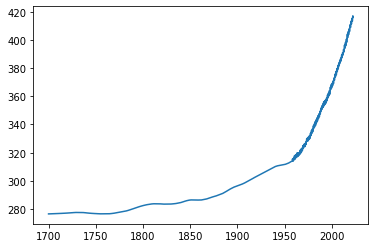

In [2]:
path_in = "global_co2_merged.txt"

data_in = pd.read_table(path_in, skiprows=16, skipinitialspace=True, sep=" ", names=["time", "CO2"])

print(data_in)

plt.plot(data_in["time"], data_in["CO2"]);

# Create xarray Dataset from input data

In [3]:
t_vals = (data_in["time"] - 1700.0) * 365.0
time = xr.DataArray(
    data=t_vals,
    coords={"time": t_vals},
    attrs={"long_name": "time", "units": "days since 1700-01-01", "calendar": "noleap"},
)
print(time)

lat_val = [0.0]
lat = xr.DataArray(
    data=lat_val, coords={"lat": lat_val}, attrs={"long_name": "latitude", "units": "degrees_north"}
)

lon_val = [180.0]
lon = xr.DataArray(
    data=lon_val, coords={"lon": lon_val}, attrs={"long_name": "longitude", "units": "degrees_east"}
)

<xarray.DataArray 'time' (time: 3868)>
array([1.53300000e+01, 4.56250000e+01, 7.62850000e+01, ...,
       1.17575625e+05, 1.17605920e+05, 1.17636580e+05])
Coordinates:
  * time     (time) float64 15.33 45.62 76.29 ... 1.176e+05 1.176e+05 1.176e+05
Attributes:
    long_name:  time
    units:      days since 1700-01-01
    calendar:   noleap


In [4]:
area = xr.DataArray(
    data=[[4.0*math.pi]],
    coords={"lat": lat, "lon": lon},
    attrs={"long_name": "grid cell area", "units": "radians^2"},
)

mask = xr.DataArray(
    data=[[1.0]],
    coords={"lat": lat, "lon": lon},
    attrs={"long_name": "Mask of active cells: 1=active", "units": "unitless"},
)

CO2 = xr.DataArray(
    data=np.expand_dims(data_in["CO2"].values, (-2, -1)),
    coords={"time": time, "lat": lat, "lon": lon},
    attrs={"long_name": "atmospheric CO2 concentration", "units": "ppmv"},
)

In [5]:
ds = xr.Dataset(
    data_vars={"time": time, "area": area, "mask": mask, "CO2": CO2}
)
ds.attrs["input_file_list"] = path_in
ds.attrs["date_created"] = f"{datetime.now()}"
ds.encoding["unlimited_dims"] = "time"
print(ds)

<xarray.Dataset>
Dimensions:  (time: 3868, lat: 1, lon: 1)
Coordinates:
  * time     (time) float64 15.33 45.62 76.29 ... 1.176e+05 1.176e+05 1.176e+05
  * lat      (lat) float64 0.0
  * lon      (lon) float64 180.0
Data variables:
    area     (lat, lon) float64 12.57
    mask     (lat, lon) float64 1.0
    CO2      (time, lat, lon) float64 276.6 276.6 276.6 ... 416.7 415.8 416.8
Attributes:
    input_file_list:  global_co2_merged.txt
    date_created:     2022-06-15 11:54:57.606138


# Write Dataset to netCDF file

In [6]:
for d in [ds.data_vars, ds.coords]:
    for varname in d:
        if "_FillValue" not in d[varname].encoding:
            d[varname].encoding["_FillValue"] = None

In [7]:
datestamp = datetime.now().strftime("%Y%m%d")
path_out = f"fco2_datm_global_GCB_2022_1700-2022_c{datestamp}.nc"
print(f"creating {path_out}")
ds.to_netcdf(path_out)

creating fco2_datm_global_GCB_2022_1700-2022_c20220615.nc


# Confirm that netCDF file can be read back in

In [8]:
ds2 = xr.open_dataset(path_out)
print(ds2)

<xarray.Dataset>
Dimensions:  (time: 3868, lat: 1, lon: 1)
Coordinates:
  * time     (time) object 1700-01-16 07:55:11.999997 ... 2022-04-17 13:55:11...
  * lat      (lat) float64 0.0
  * lon      (lon) float64 180.0
Data variables:
    area     (lat, lon) float64 ...
    mask     (lat, lon) float64 ...
    CO2      (time, lat, lon) float64 ...
Attributes:
    input_file_list:  global_co2_merged.txt
    date_created:     2022-06-15 11:54:57.606138
